Regresión lineal del Boston Housing dataset usando estimadores
===

* *30 min* | Última modificación: Abril 6, 2020.

Basado en https://www.tensorflow.org/tutorials/keras/classification y Learn TensorFlow 2.0, P. Singh and A. Manure

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0


## Carga y configuración del dataset

In [2]:
from sklearn import datasets

#
#  Carga del dataset
#
dataset = datasets.load_boston()
feature_columns = dataset.feature_names
target_column = dataset.target

#
#  Construye un DataFrame de pandas para realizar
#  análisis exploratorio. `data` no contiene la
#   variable dependiente.
#
df = pd.DataFrame(dataset.data, columns=feature_columns).astype(np.float32)

#
#  Agrega la variable dependiente.
#
df["MEDV"] = target_column.astype(np.float32)

#
#  Verificación.
#
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.199997,4.0900,1.0,296.0,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900002,4.9671,2.0,242.0,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.099998,4.9671,2.0,242.0,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.799999,6.0622,3.0,222.0,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200001,6.0622,3.0,222.0,18.700001,396.899994,5.33,36.200001


## Exploración del dataset

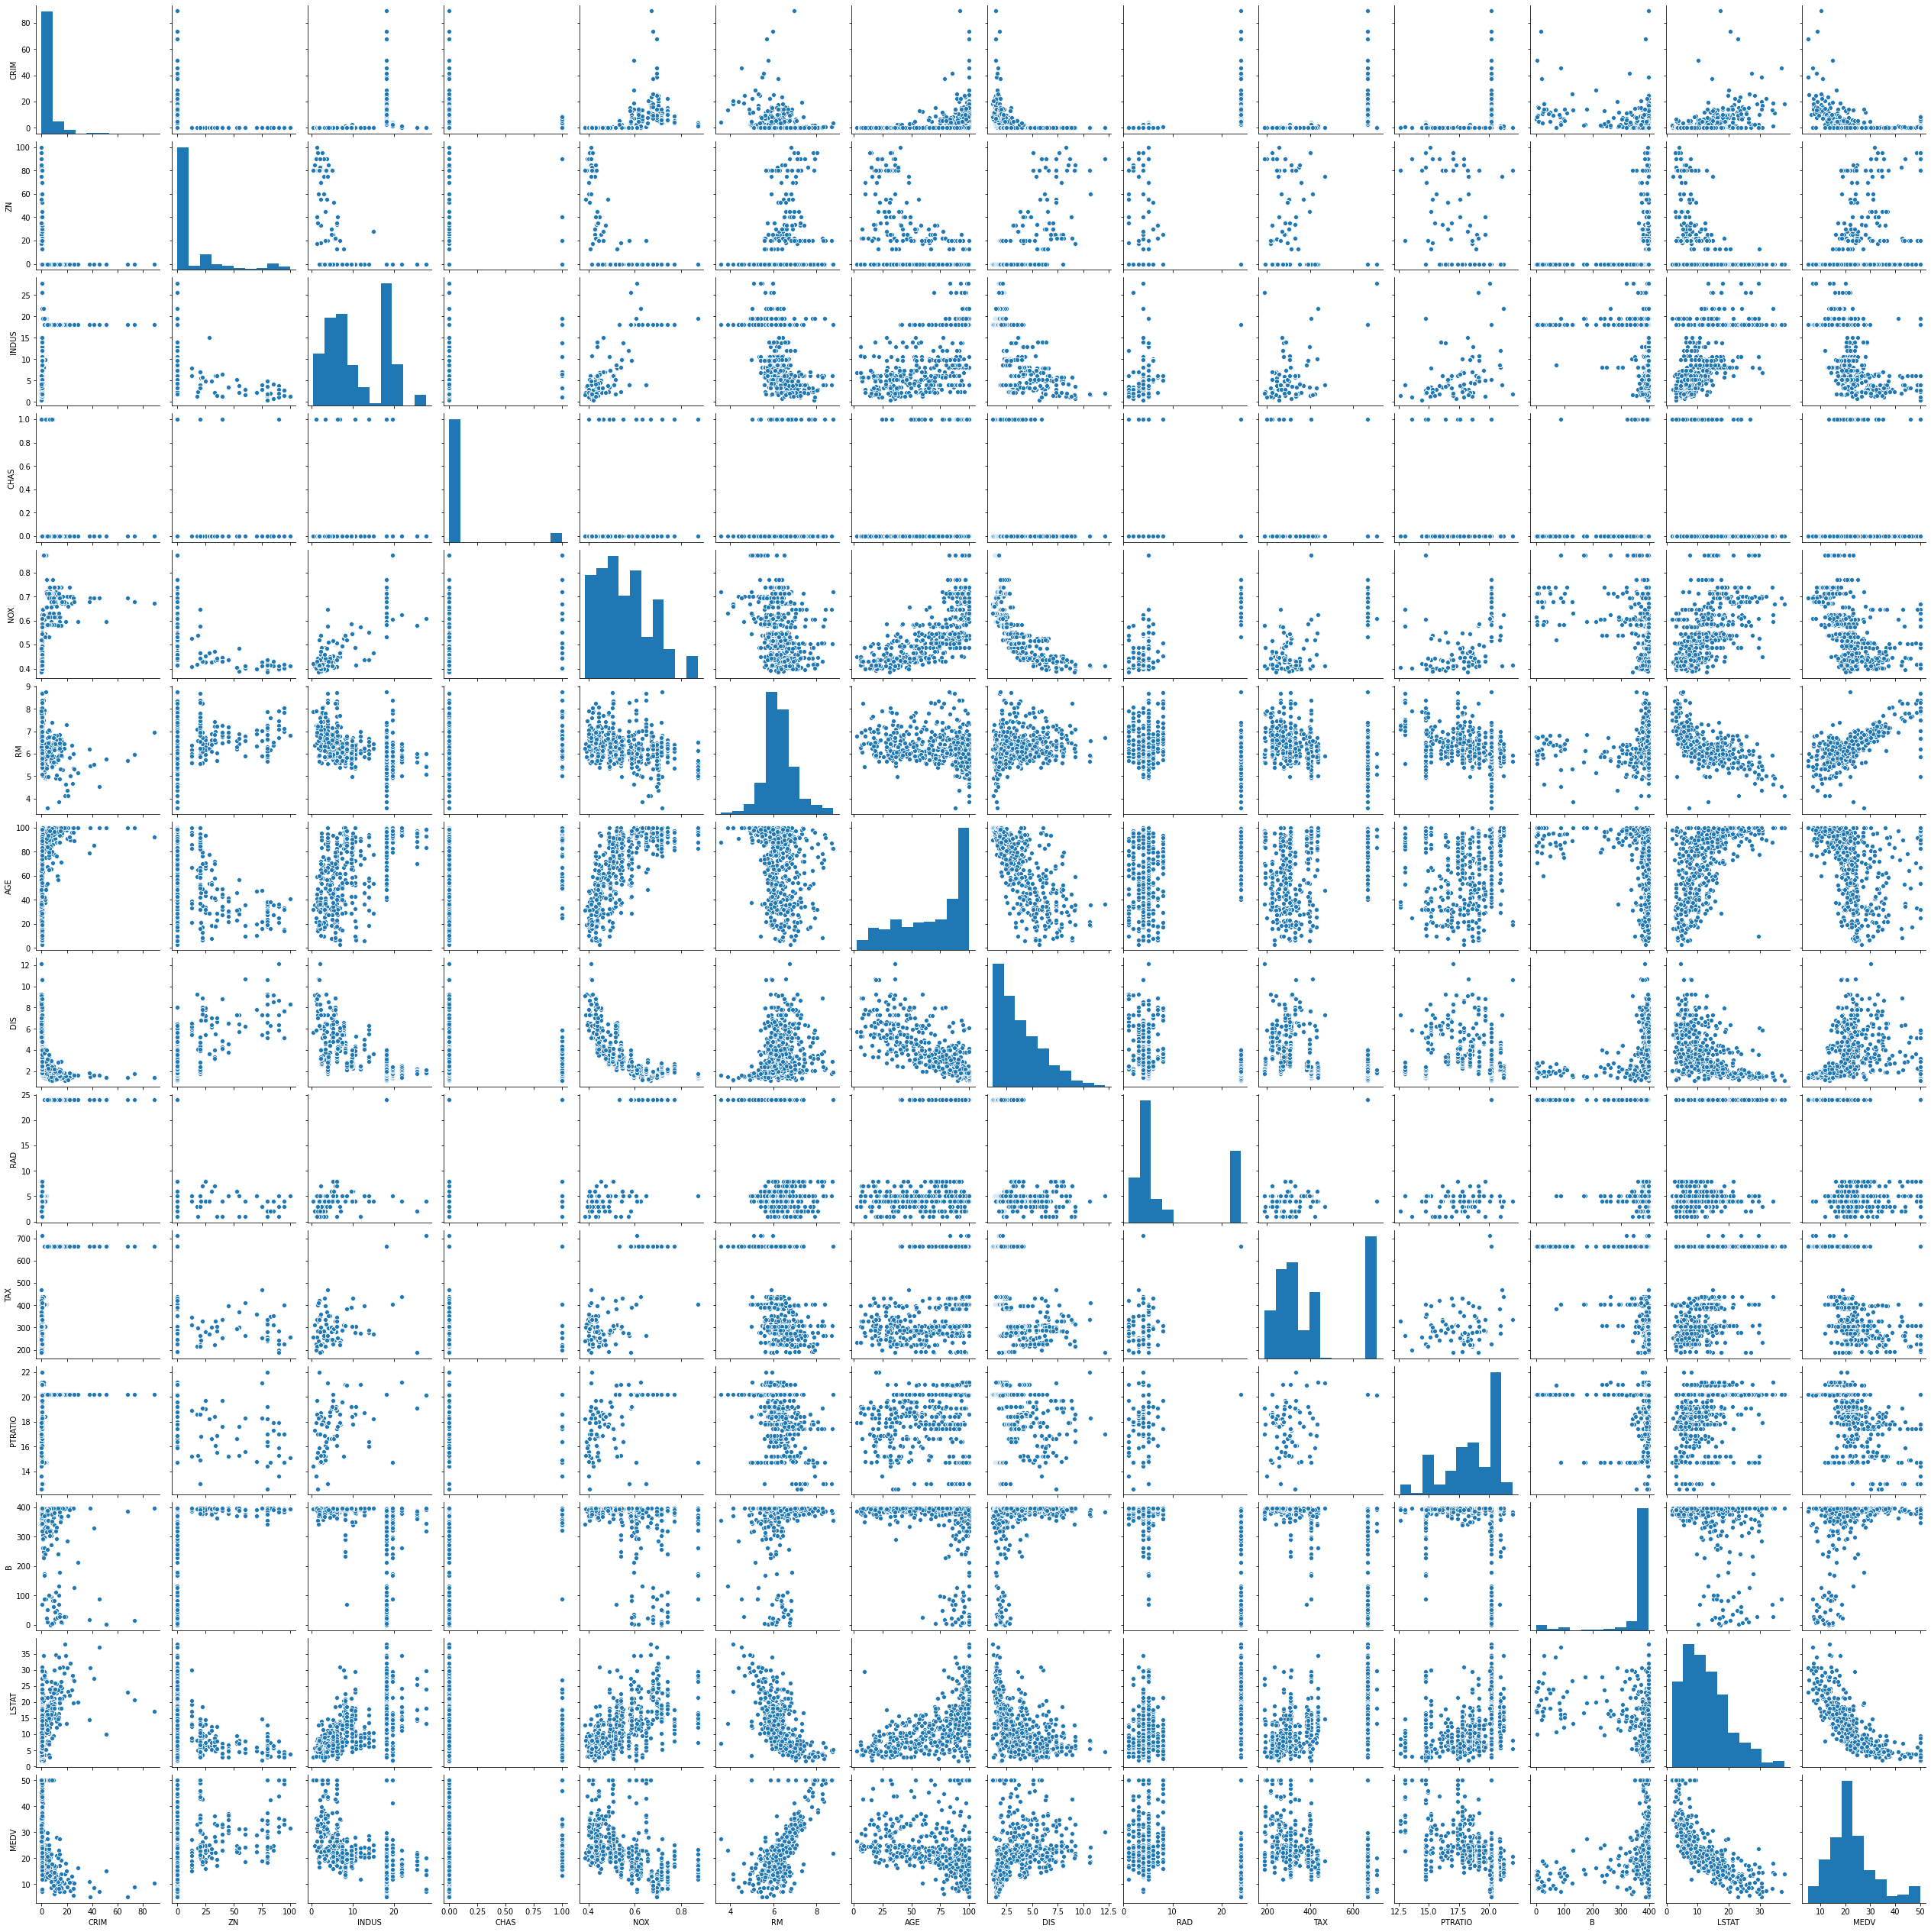

In [3]:
sb.pairplot(df, diag_kind="auto")

In [4]:
#
#  Correlación entre las variables
#
df.corr().style.background_gradient(cmap="coolwarm", axis=None)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355502,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [5]:
#
#  Estadísticos descriptivos
#
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.256510,3.677083,88.976196
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.000000,12.500000,100.000000
INDUS,506.0,11.136780,6.860353,0.46000,5.190000,9.690000,18.100000,27.740000
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.000000,0.000000,1.000000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.538000,0.624000,0.871000
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.208500,6.623500,8.780000
AGE,506.0,68.574898,28.148861,2.90000,45.025000,77.500000,94.074999,100.000000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.207450,5.188425,12.126500
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.000000,24.000000,24.000000
TAX,506.0,408.237152,168.537109,187.00000,279.000000,330.000000,666.000000,711.000000


## Conjuntos de entrenamiento y validación

In [6]:
from sklearn.model_selection import train_test_split

#
#  Partición de los datos. La función retorno un objeto
#  pandas.DataFrame para X y un objeto pandas.Series para
#  y
#
X_train, X_test, y_train, y_test = train_test_split(
    df[[c for c in df.columns if c != "MEDV"]], df["MEDV"], test_size=0.2
)

## Escalamiento de los datos

In [7]:
from sklearn import preprocessing

#
#  El preprocesador retorna una numpy.ndarray y debe
#  transformarse nuevamente en un pandas.DataFrame
#
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns).astype(
    np.float32
)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns).astype(
    np.float32
)

## Especificación de los parámetros del estimador

In [8]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds

    return input_function


train_input_fn = make_input_fn(X_train, y_train, num_epochs=1, shuffle=False)

test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [9]:
#
#  Crea una lista con los tipos de las columnas
#  del dataframe de entrada
#
feature_columns = [tf.feature_column.numeric_column(m) for m in X_train.columns]

## Entrenamiento

In [10]:
linear_model = tf.estimator.LinearRegressor(
    feature_columns=feature_columns, optimizer="RMSProp"
)

linear_model.train(train_input_fn)

## Pronósticos

In [11]:
#
#  La predicción del modelo son generadores por lo que
#  deben transformarse en pandas.Series.
#
y_train_predictions = linear_model.predict(train_input_fn)
y_train_predictions = pd.Series([p["predictions"][0] for p in y_train_predictions])

y_test_predictions = linear_model.predict(test_input_fn)
y_test_predictions = pd.Series([p["predictions"][0] for p in y_test_predictions])

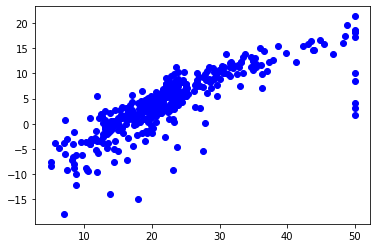

In [12]:
#
# Conjutno de entrenamiento
#
plt.plot(y_train, y_train_predictions, "ob")

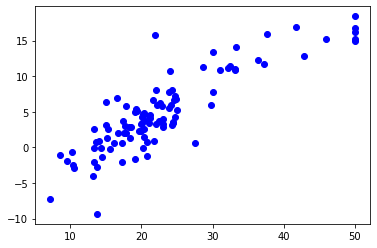

In [13]:
#
# Conjutno de prueba
#
plt.plot(y_test, y_test_predictions, "ob")

## Métricas de error

In [14]:
from sklearn.metrics import mean_squared_error, r2_score


def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = mean_squared_error(y_true, y_pred)
    root_mean_squared_err = np.sqrt(mean_squared_err)
    r2 = round(r2_score(y_true, y_pred) * 100, 0)
    return mean_squared_err, root_mean_squared_err, r2


(
    train_mean_squared_error,
    train_root_mean_squared_error,
    train_r2_score_percentage,
) = calculate_errors_and_r2(y_train, y_train_predictions)

(
    test_mean_squared_error,
    test_root_mean_squared_error,
    test_r2_score_percentage,
) = calculate_errors_and_r2(y_test, y_test_predictions)

print("Training Data Mean Squared Error = ", train_mean_squared_error)
print("Training Data Root Mean Squared Error = ", train_root_mean_squared_error)
print("Training Data R2 = ", train_r2_score_percentage)
print("Test Data Mean Squared Error = ", test_mean_squared_error)
print("Test Data R2 = ", test_r2_score_percentage)

Training Data Mean Squared Error =  364.0442145016434
Training Data Root Mean Squared Error =  19.07994272794453
Training Data R2 =  -338.0
Test Data Mean Squared Error =  356.3875880046798
Test Data R2 =  -297.0
